In [1]:
# # Uninstall conflicting packages first
# !pip uninstall -y numpy scipy gensim tensorflow

# # Reinstall compatible versions
# !pip install numpy==1.24.3 scipy==1.10.1 gensim==4.3.1 tensorflow==2.13.0



In [2]:
# !pip install numpy

In [3]:
# ! pip install tensorflow

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

# Install the contractions library
!pip install contractions
import contractions
import pickle
import os
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

# Download necessary NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

print("Starting Book Review Rating Prediction System...")
print("--" * 80)

Starting Book Review Rating Prediction System...
----------------------------------------------------------------------------------------------------------------------------------------------------------------


In [5]:
# Mount Google Drive (if using Colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Part 1: Text Preprocessing, Tokenization & Padding (5 marks)

We'll start by loading and preprocessing the dataset, visualizing the data, and preparing it for model training.



## 1.1 Load Dataset

First, we need to load the dataset using Pandas. The dataset should have at least two columns: `reviewText` for the text content of the review and `rating` for the numerical rating (1-5).

In [6]:
# Load the dataset
file_path = "/content/drive/MyDrive/Book_review.csv"
df = pd.read_csv(file_path)

In [7]:
# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())



Dataset shape: (12000, 4)

First 5 rows:
   Unnamed: 0  rating                                         reviewText  \
0           0       5  This book was the very first bookmobile book I...   
1           1       1  When I read the description for this book, I c...   
2           2       5  I just had to edit this review. This book is a...   
3           3       5  I don't normally buy 'mystery' novels because ...   
4           4       5  This isn't the kind of book I normally read, a...   

                           summary  
0                50 + years ago...  
1          Boring! Boring! Boring!  
2  Wiggleliscious/new toy ready/!!  
3                  Very good read.  
4                     Great Story!  


In [8]:
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())




Missing values:
Unnamed: 0    0
rating        0
reviewText    0
summary       2
dtype: int64


In [9]:
# Check the distribution of ratings
print("\nRating distribution:")
print(df['rating'].value_counts().sort_index())


Rating distribution:
rating
1    2000
2    2000
3    2000
4    3000
5    3000
Name: count, dtype: int64


## 1.2 Clean Text

Now we'll clean the text data by:
- Converting to lowercase
- Removing URLs, mentions (@user), hashtags (#), numbers, and special characters
- Expanding contractions (e.g., "don't" → "do not")
- Removing stopwords and lemmatizing words

Let's define a function to handle all these preprocessing steps:

In [10]:
# Define a function to clean the text
def clean_text(text):
    """
    Function to clean and preprocess text data

    Args:
        text (str): Input text

    Returns:
        str: Cleaned text
    """
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Expand contractions
    text = contractions.fix(text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove mentions (@user)
    text = re.sub(r'@\w+', '', text)

    # Remove hashtags (#)
    text = re.sub(r'#\w+', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords but keep negation words
    lemmatizer = WordNetLemmatizer()
    negation_words = {'no', 'not', 'never', 'none', 'nobody', 'nothing', 'neither', 'nowhere', 'hardly', 'barely'}
    stop_words = set(stopwords.words('english')) - negation_words
    clean_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    # Join tokens back into a string
    return ' '.join(clean_tokens)


In [11]:
nltk.download('punkt_tab', quiet=True) # Add this line to download the missing resource

True

In [12]:
# Apply the cleaning function to the review text
df['cleaned_text'] = df['reviewText'].apply(clean_text)



In [13]:
# Display the first few cleaned reviews
print("Original vs. Cleaned Text:")
for i in range(3):
    print(f"\nOriginal: {df['reviewText'].iloc[i][:100]}...")
    print(f"Cleaned: {df['cleaned_text'].iloc[i][:100]}...")



Original vs. Cleaned Text:

Original: This book was the very first bookmobile book I bought when I was in the school book club. I loved th...
Cleaned: book first bookmobile book bought school book club loved story bet dollar donut love memory serf bou...

Original: When I read the description for this book, I couldn't wait to read it. Once I downloaded it to my Ki...
Cleaned: read description book could not wait read downloaded kindle found extremely hard keep reading honest...

Original: I just had to edit this review. This book is an (I believe I got this right) an updated re-write. Th...
Cleaned: edit review book believe got right updated rewrite thank god not get first version moved top favorit...


In [14]:
# Check for empty cleaned texts
empty_texts = df['cleaned_text'].str.strip().eq('')
print(f"\nNumber of empty texts after cleaning: {empty_texts.sum()}")




Number of empty texts after cleaning: 0


In [15]:
# Remove rows with empty cleaned texts if any
if empty_texts.sum() > 0:
    df = df[~empty_texts]
    print(f"Removed {empty_texts.sum()} rows with empty cleaned texts.")
    print(f"New dataset shape: {df.shape}")

## 1.3 Visualize Data

Now that we have cleaned the text data, we'll create three visualizations:
1. A word cloud of the cleaned text
2. A bar chart of the top 20 most frequent words
3. A histogram of the rating distribution

In [16]:
# Create a corpus of all cleaned text
corpus = ' '.join(df['cleaned_text'])

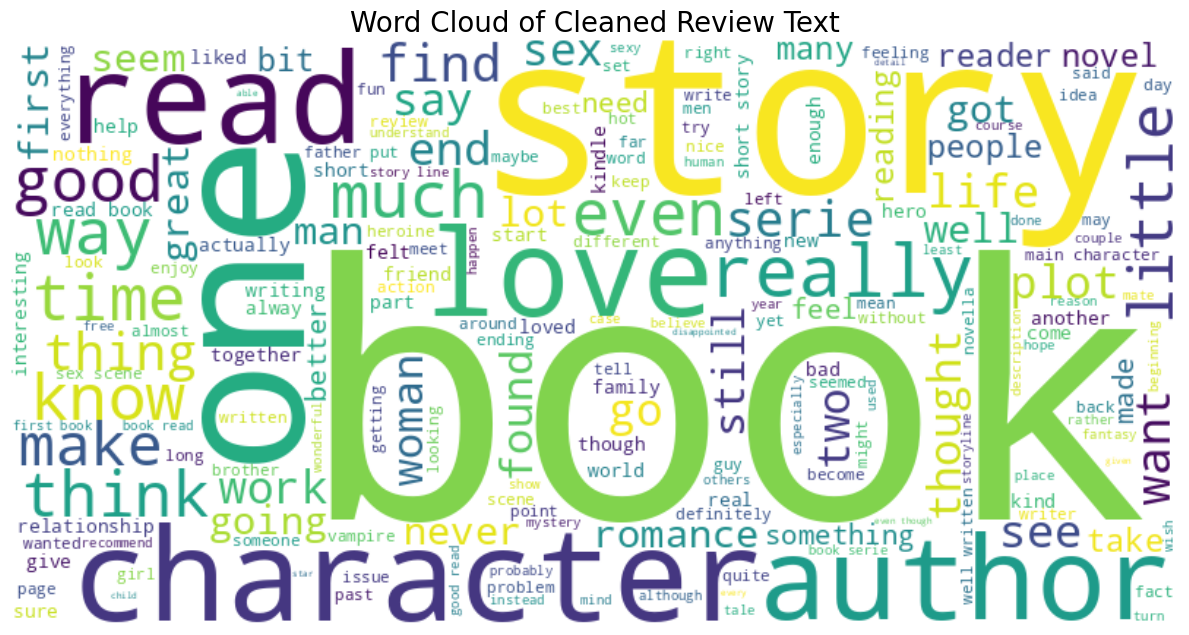

In [17]:
# 1. Generate a word cloud
plt.figure(figsize=(12, 8))
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200,
    contour_width=3,
    colormap='viridis'
).generate(corpus)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Review Text', fontsize=20)
plt.tight_layout()
plt.show()

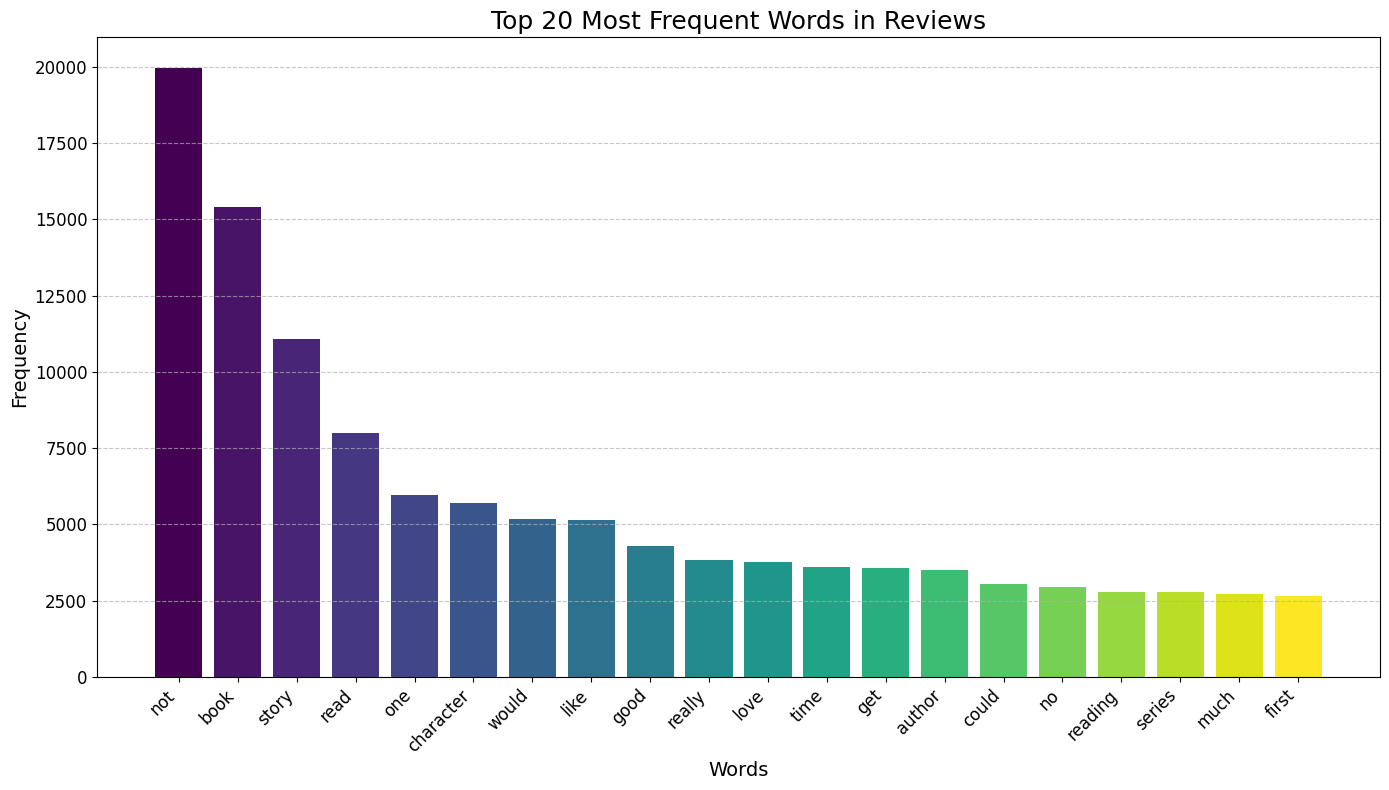

In [18]:
# 2. Plot a bar chart of the top 20 most frequent words
# Count word frequencies
word_counts = Counter(corpus.split())
top_words = dict(word_counts.most_common(20))

plt.figure(figsize=(14, 8))
plt.bar(
    top_words.keys(),
    top_words.values(),
    color=plt.cm.viridis(np.linspace(0, 1, len(top_words)))
)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.title('Top 20 Most Frequent Words in Reviews', fontsize=18)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

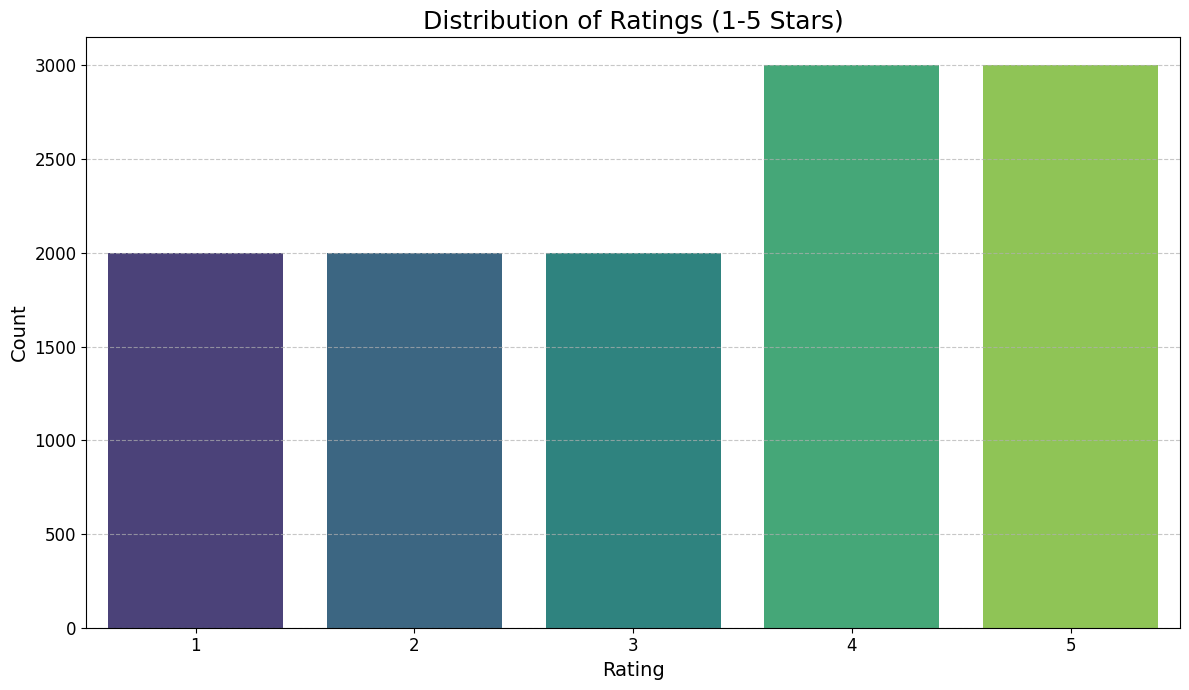


Rating Distribution Statistics:
count    12000.000000
mean         3.250000
std          1.421619
min          1.000000
25%          2.000000
50%          3.500000
75%          4.250000
max          5.000000
Name: rating, dtype: float64

Percentage of each rating:
Rating 1: 16.67%
Rating 2: 16.67%
Rating 3: 16.67%
Rating 4: 25.00%
Rating 5: 25.00%


In [19]:
# 3. Show a histogram of rating distribution
plt.figure(figsize=(12, 7))
sns.countplot(
    x='rating',
    data=df,
    palette='viridis',
    order=sorted(df['rating'].unique())
)
plt.title('Distribution of Ratings (1-5 Stars)', fontsize=18)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print some statistics about the ratings
print("\nRating Distribution Statistics:")
print(df['rating'].describe())
print("\nPercentage of each rating:")
rating_percentages = df['rating'].value_counts(normalize=True).sort_index() * 100
for rating, percentage in rating_percentages.items():
    print(f"Rating {rating}: {percentage:.2f}%")

## 1.4 Tokenization & Padding

Now we'll:
1. Split the data into training (80%) and testing (20%) sets
2. Convert the text to integer sequences using `Tokenizer()`
3. Pad the sequences to a uniform length (using the 95th percentile to avoid excessive padding)

In [20]:
# Prepare features and target
X = df['cleaned_text'].values
# Convert ratings from 1-5 to 0-4 for model output
y = df['rating'].values - 1

In [21]:
# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Ensure balanced classes in both splits
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 9600 samples
Testing set size: 2400 samples


In [22]:
# Create tokenizer
max_vocab_size = 10000  # Limit vocabulary size to avoid memory issues
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

In [23]:
# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [24]:
# Check vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # +1 for the 0 padding
print(f"Vocabulary size: {vocab_size} words")

Vocabulary size: 35998 words


In [25]:
# Get some sample sequences
print("\nSample sequence:")
print(f"Original text: {X_train[0]}")
print(f"Tokenized sequence: {X_train_seq[0][:20]}...")


Sample sequence:
Original text: well written good read not ending expected pleasure read buy next book sure
Tokenized sequence: [22, 51, 10, 5, 2, 112, 372, 724, 5, 222, 95, 3, 118]...


In [26]:
# Calculate sequence lengths
train_seq_lengths = [len(seq) for seq in X_train_seq]

In [27]:
# Calculate statistics on sequence lengths
max_length = max(train_seq_lengths)
mean_length = np.mean(train_seq_lengths)
median_length = np.median(train_seq_lengths)
percentile_95 = int(np.percentile(train_seq_lengths, 95))

print(f"\nSequence length statistics:")
print(f"Maximum length: {max_length}")
print(f"Mean length: {mean_length:.2f}")
print(f"Median length: {median_length}")
print(f"95th percentile: {percentile_95}")


Sequence length statistics:
Maximum length: 1106
Mean length: 54.84
Median length: 30.5
95th percentile: 183


In [28]:
# Use the 95th percentile for padding length
max_length = percentile_95

In [29]:
# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

print(f"\nShape of padded training data: {X_train_pad.shape}")
print(f"Shape of padded testing data: {X_test_pad.shape}")


Shape of padded training data: (9600, 183)
Shape of padded testing data: (2400, 183)


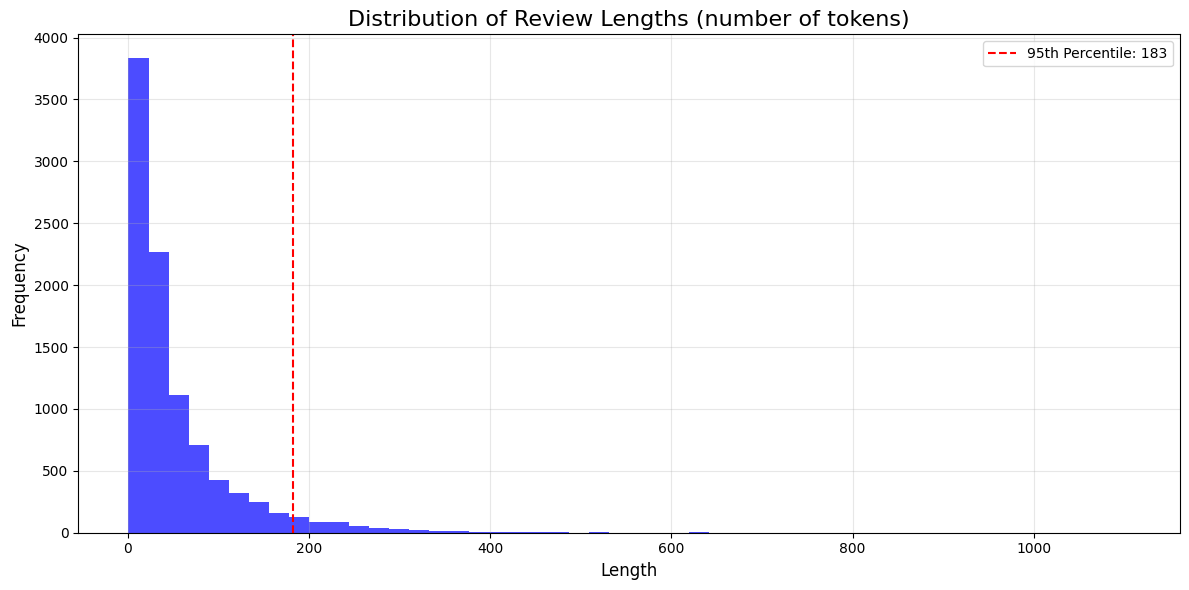

In [30]:
# Visualize the distribution of sequence lengths
plt.figure(figsize=(12, 6))
plt.hist(train_seq_lengths, bins=50, alpha=0.7, color='blue')
plt.axvline(x=percentile_95, color='red', linestyle='--',
            label=f'95th Percentile: {percentile_95}')
plt.title('Distribution of Review Lengths (number of tokens)', fontsize=16)
plt.xlabel('Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [31]:
# Save tokenizer and max_length for later use in the GUI
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
with open('max_length.pkl', 'wb') as f:
    pickle.dump(max_length, f)

print("\nTokenization and padding completed successfully!")


Tokenization and padding completed successfully!


# Part 2: Model Building (7 marks)

In this section, we'll build and compare three different models:
1. Simple RNN
2. LSTM
3. LSTM with pretrained word embeddings (GloVe)

Let's implement each model one by one.

In [32]:
# Set the embedding dimension for all models
embedding_dim = 50

# Model 1: Simple RNN
print("Building Simple RNN model...")

# Create the model
model1 = Sequential([
    # Embedding Layer: Randomly initialized, trainable embeddings
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=max_length,
              trainable=True,
              name='embedding_layer'),

    # RNN Layer: SimpleRNN with 64 units
    SimpleRNN(units=64,
              return_sequences=False,  # Return only the last output
              name='simple_rnn_layer'),

    # Output Layer: Dense layer with softmax activation for 5-class classification
    Dense(units=5,
          activation='softmax',
          name='output_layer')
])

# Compile the model
model1.compile(
    loss='sparse_categorical_crossentropy',  # Since ratings are integers 0-4
    optimizer='adam',
    metrics=['accuracy']
)

# Display the model summary
print("\nModel 1: Simple RNN Summary")
model1.summary()

Building Simple RNN model...

Model 1: Simple RNN Summary


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_layer (SimpleRNN)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Model 2: LSTM
print("Building LSTM model...")

# Create the model
model2 = Sequential([
    # Embedding Layer: Same as Model 1 (trainable)
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=max_length,
              trainable=True,
              name='embedding_layer'),

    # RNN Layer: Replace SimpleRNN with LSTM (64 units)
    LSTM(units=64,
         return_sequences=False,  # Return only the last output
         name='lstm_layer'),

    # Output Layer: Same as Model 1
    Dense(units=5,
          activation='softmax',
          name='output_layer')
])

# Compile the model
model2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Display the model summary
print("\nModel 2: LSTM Summary")
model2.summary()

Building LSTM model...

Model 2: LSTM Summary


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [34]:
!pip install gensim

In [35]:
import gensim.downloader as gensim_downloader


In [36]:
import numpy as np
 # Model 3: LSTM + Pretrained Word2Vec
print("Building LSTM model with pretrained word embeddings...")

# Load pretrained GloVe embeddings (50-dimensional)
print("Loading pretrained GloVe embeddings (this may take a few minutes)...")
word_vectors = gensim_downloader.load('glove-wiki-gigaword-50')
print(f"Loaded {len(word_vectors.key_to_index)} word vectors")

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
words_found = 0

# Map vocabulary words to pretrained vectors
for word, i in tokenizer.word_index.items():
    if i >= vocab_size:  # Only process words in our vocabulary limit
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
        words_found += 1
    except KeyError:
        # Word not in embedding space, remains as zeros
        pass

print(f"Found embeddings for {words_found} words out of {min(vocab_size-1, len(tokenizer.word_index))} words")
print(f"Coverage: {words_found / min(vocab_size-1, len(tokenizer.word_index)) * 100:.2f}%")


# Create the model
model3 = Sequential([
    # Embedding Layer: Pretrained GloVe embeddings (non-trainable)
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=max_length,
              weights=[embedding_matrix],  # Use pretrained weights
              trainable=False,  # Freeze embeddings
              name='pretrained_embedding_layer'),

    # Replace simple LSTM with bidirectional architecture
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.3),

    # Add dense layer before output
    Dense(64, activation='relu'),
    Dense(units=5,
          activation='softmax',
          name='output_layer')
])

# Compile the model
model3.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Display the model summary
print("\nModel 3: LSTM + GloVe Summary")
model3.summary()

Building LSTM model with pretrained word embeddings...
Loading pretrained GloVe embeddings (this may take a few minutes)...
[==================================================] 100.0% 66.0/66.0MB downloaded
Loaded 400000 word vectors
Found embeddings for 20993 words out of 35997 words
Coverage: 58.32%

Model 3: LSTM + GloVe Summary


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ pretrained_embedding_layer      │ ?                      │     1,799,900 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,799,900 (6.87 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,799,900 (6.87 MB)

In [37]:
# Ensure models are built before calling count_params
model1.build(input_shape=(None, max_length))
model2.build(input_shape=(None, max_length))
model3.build(input_shape=(None, max_length))

In [38]:
# Create an overview table of the three models
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Model", "Embedding", "RNN Type", "Trainable Parameters"]
table.add_row(["Model 1", "Random (Trainable)", "SimpleRNN", f"{model1.count_params():,}"])
table.add_row(["Model 2", "Random (Trainable)", "LSTM", f"{model2.count_params():,}"])
table.add_row(["Model 3", "GloVe (Frozen)", "LSTM", f"{model3.count_params():,}"])

print("\nModel Comparison:")
print(table)


Model Comparison:
+---------+--------------------+-----------+----------------------+
|  Model  |     Embedding      |  RNN Type | Trainable Parameters |
+---------+--------------------+-----------+----------------------+
| Model 1 | Random (Trainable) | SimpleRNN |      1,807,585       |
| Model 2 | Random (Trainable) |    LSTM   |      1,829,665       |
| Model 3 |   GloVe (Frozen)   |    LSTM   |      2,156,129       |
+---------+--------------------+-----------+----------------------+


# Part 3: Model Training & Evaluation (5 marks)

Now we'll train and evaluate all three models. For each model, we will:

1. **Compile** with:
   - Loss: `sparse_categorical_crossentropy`
   - Optimizer: Adam
   - Metrics: Accuracy

2. **Train** with:
   - Early stopping (monitor `val_loss`, patience=3)
   - Up to 20 epochs with batch size 32

3. **Evaluate** using:
   - Loss and accuracy curves
   - Confusion matrices
   - Classification reports

Let's start by defining some helper functions for evaluation and visualization:

In [39]:
# Define functions for model evaluation

def plot_learning_curves(history, model_name):
    """Plot training vs validation accuracy and loss curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{model_name} - Accuracy', fontsize=16)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)

    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{model_name} - Loss', fontsize=16)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, class_names, title):
    """Plot confusion matrix with better visualization"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title, fontsize=16)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.tight_layout()
    plt.show()

def evaluate_model(model, X_test_pad, y_test, model_name):
    """Evaluate model performance and display results"""
    # Get predictions
    y_pred_prob = model.predict(X_test_pad)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Create class names (adjust for 0-4 to 1-5 star display)
    class_names = [f'{i+1} Star' for i in range(5)]

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Print classification report
    print(f"\n{model_name} - Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Plot confusion matrix
    plot_confusion_matrix(cm, class_names, f'{model_name} - Confusion Matrix')

    # Calculate and print accuracy
    accuracy = np.sum(y_pred == y_test) / len(y_test)
    print(f"{model_name} - Test Accuracy: {accuracy:.4f}")

    return accuracy, y_pred


TRAINING AND EVALUATING MODELS

Training Model 1: Simple RNN
Epoch 1/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2381 - loss: 1.6046 - val_accuracy: 0.2516 - val_loss: 1.5960
Epoch 2/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.2698 - loss: 1.5843 - val_accuracy: 0.2547 - val_loss: 1.6010
Epoch 3/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.2594 - loss: 1.5967 - val_accuracy: 0.2505 - val_loss: 1.6067
Epoch 4/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.2686 - loss: 1.5909 - val_accuracy: 0.2432 - val_loss: 1.6058
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
Training time for Model 1 (Simple RNN): 23.63 seconds


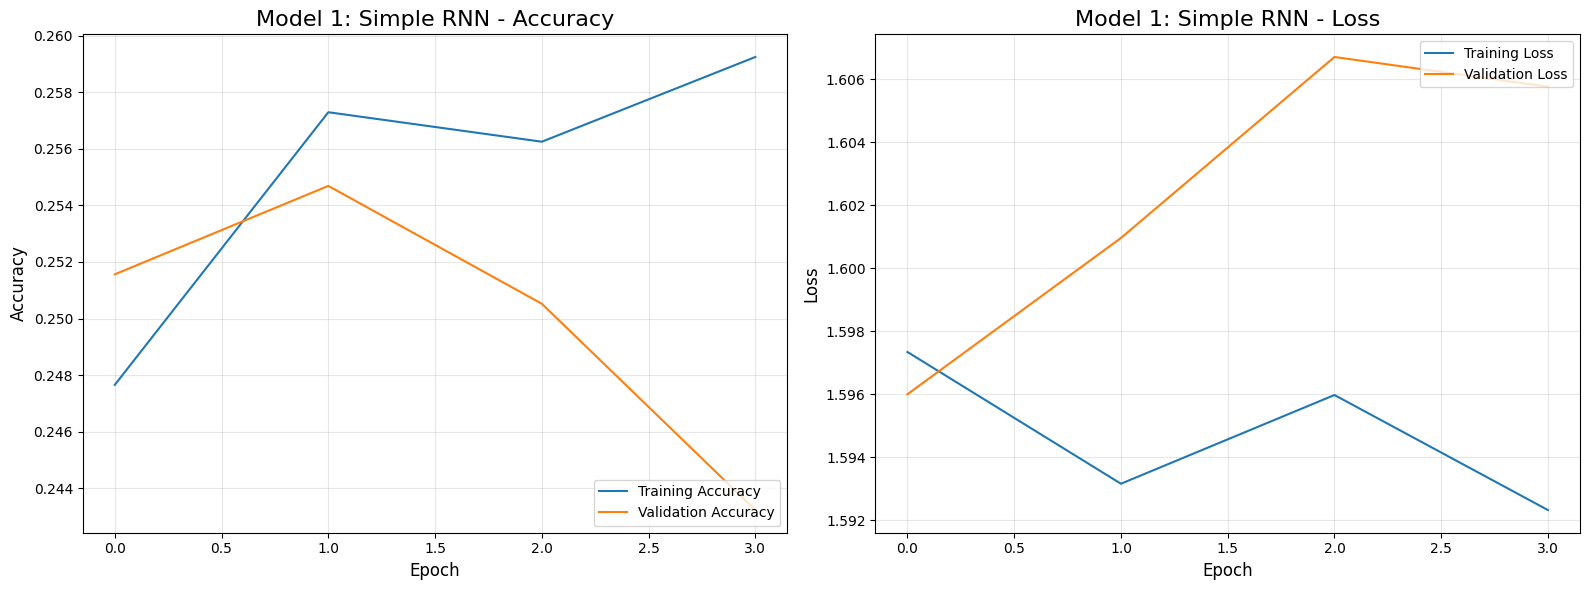


Evaluating Model 1: Simple RNN
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Model 1: Simple RNN - Classification Report:
              precision    recall  f1-score   support

      1 Star       0.50      0.00      0.00       400
      2 Star       0.50      0.00      0.00       400
      3 Star       0.15      0.01      0.01       400
      4 Star       0.32      0.03      0.05       600
      5 Star       0.25      0.98      0.40       600

    accuracy                           0.25      2400
   macro avg       0.35      0.20      0.09      2400
weighted avg       0.34      0.25      0.12      2400



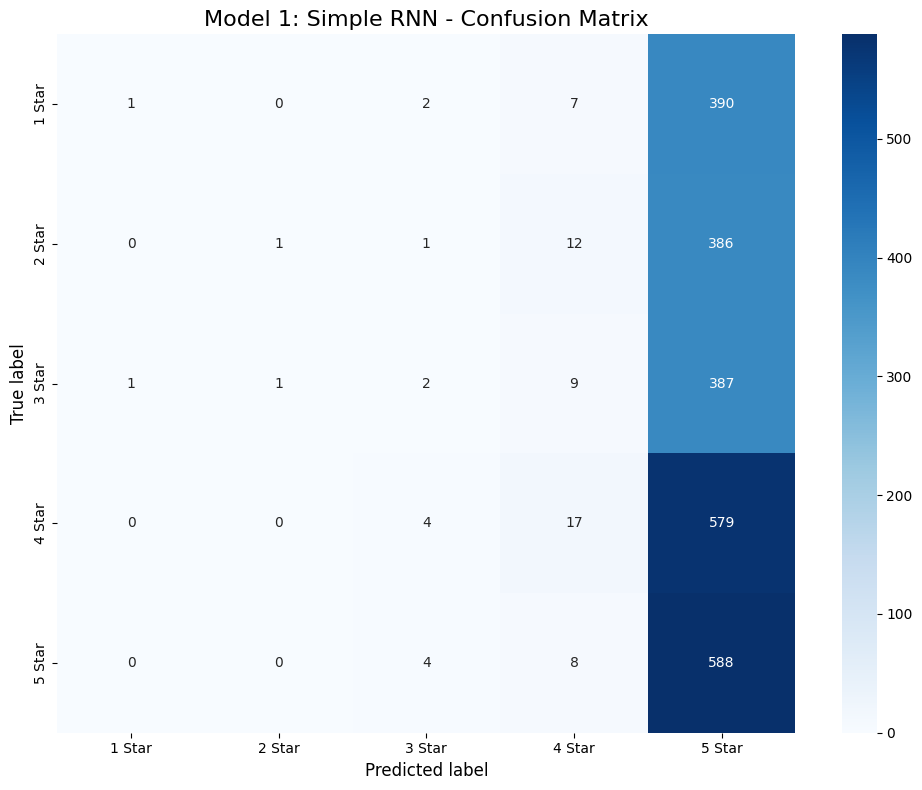

Model 1: Simple RNN - Test Accuracy: 0.2537

Training Model 2: LSTM
Epoch 1/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.2475 - loss: 1.5936 - val_accuracy: 0.2443 - val_loss: 1.5902
Epoch 2/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2582 - loss: 1.5892 - val_accuracy: 0.2516 - val_loss: 1.5918
Epoch 3/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2619 - loss: 1.5870 - val_accuracy: 0.2542 - val_loss: 1.5966
Epoch 4/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.2717 - loss: 1.5647 - val_accuracy: 0.2453 - val_loss: 1.5987
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
Training time for Model 2 (LSTM): 16.02 seconds


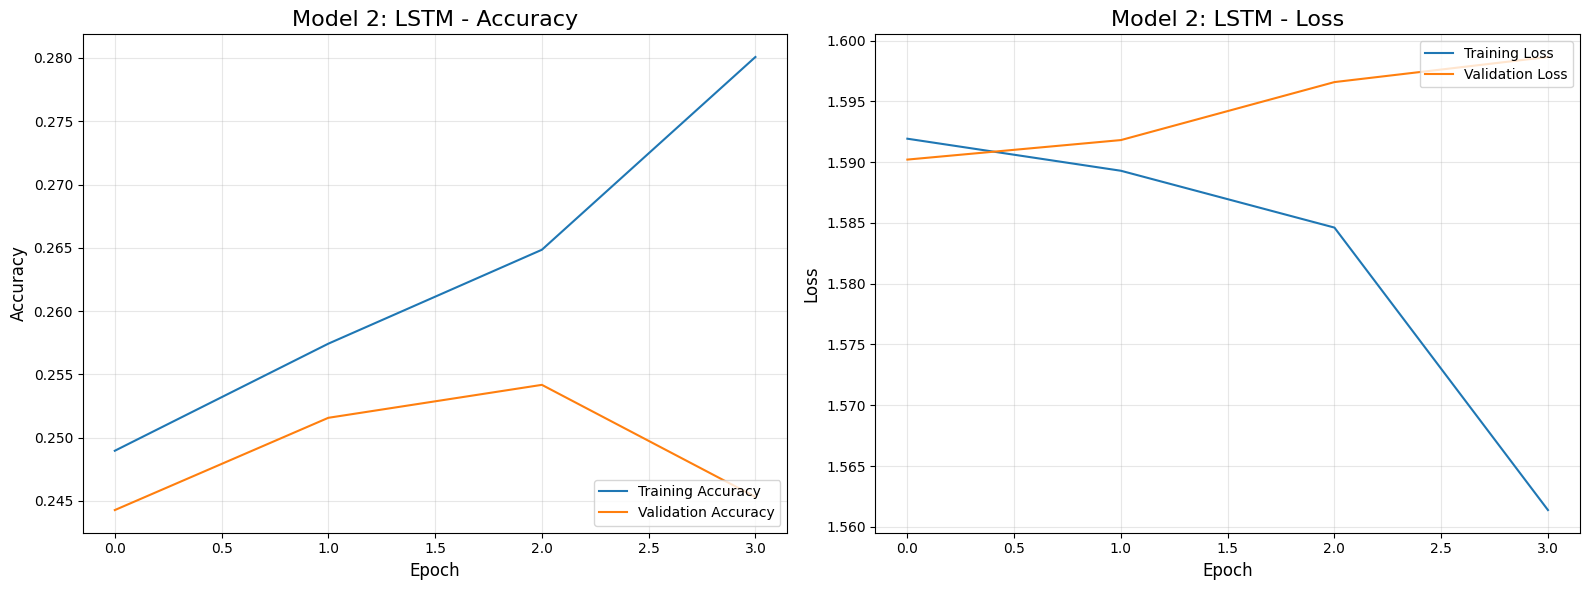


Evaluating Model 2: LSTM
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Model 2: LSTM - Classification Report:
              precision    recall  f1-score   support

      1 Star       0.00      0.00      0.00       400
      2 Star       0.00      0.00      0.00       400
      3 Star       0.00      0.00      0.00       400
      4 Star       0.32      0.01      0.02       600
      5 Star       0.25      1.00      0.40       600

    accuracy                           0.25      2400
   macro avg       0.11      0.20      0.08      2400
weighted avg       0.14      0.25      0.11      2400



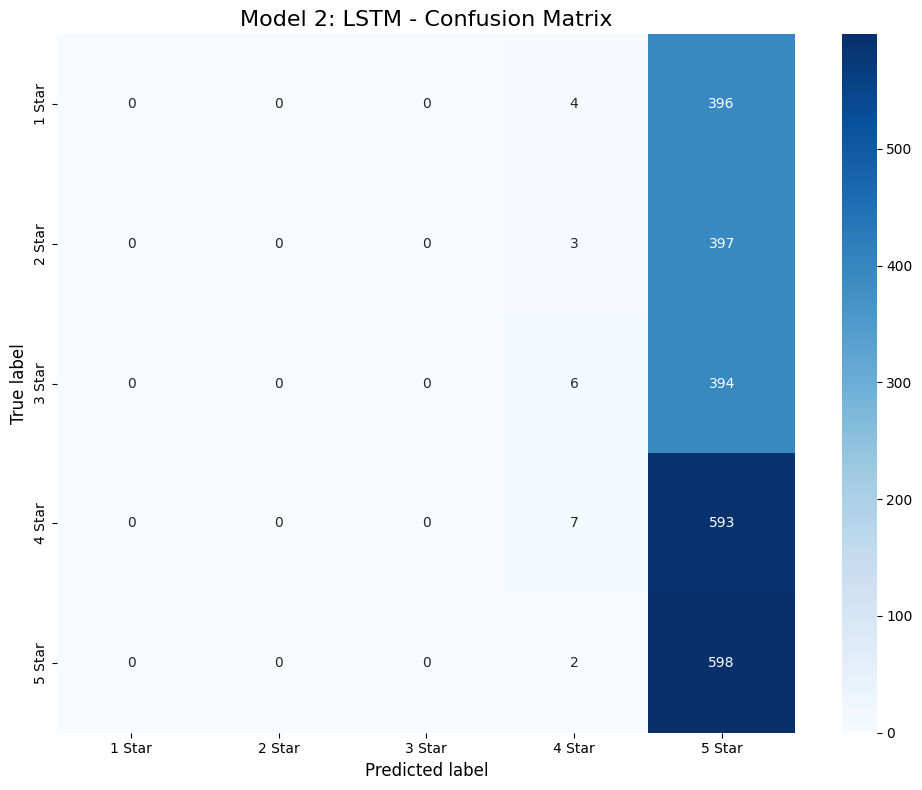

Model 2: LSTM - Test Accuracy: 0.2521

Training Model 3: LSTM with GloVe
Epoch 1/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.2629 - loss: 1.5489 - val_accuracy: 0.3630 - val_loss: 1.4204
Epoch 2/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.3825 - loss: 1.4085 - val_accuracy: 0.3620 - val_loss: 1.4464
Epoch 3/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.3895 - loss: 1.3802 - val_accuracy: 0.3766 - val_loss: 1.3688
Epoch 4/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.3288 - loss: 1.5411 - val_accuracy: 0.3568 - val_loss: 1.4650
Epoch 5/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.3845 - loss: 1.3900 - val_accuracy: 0.3672 - val_loss: 1.3799
Epoch 6/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.3906 - loss: 1.3693 - val_accuracy: 0.3625 - val_loss: 1.3774
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.
Training time for Model 3 (LSTM with GloVe): 50.90 seconds


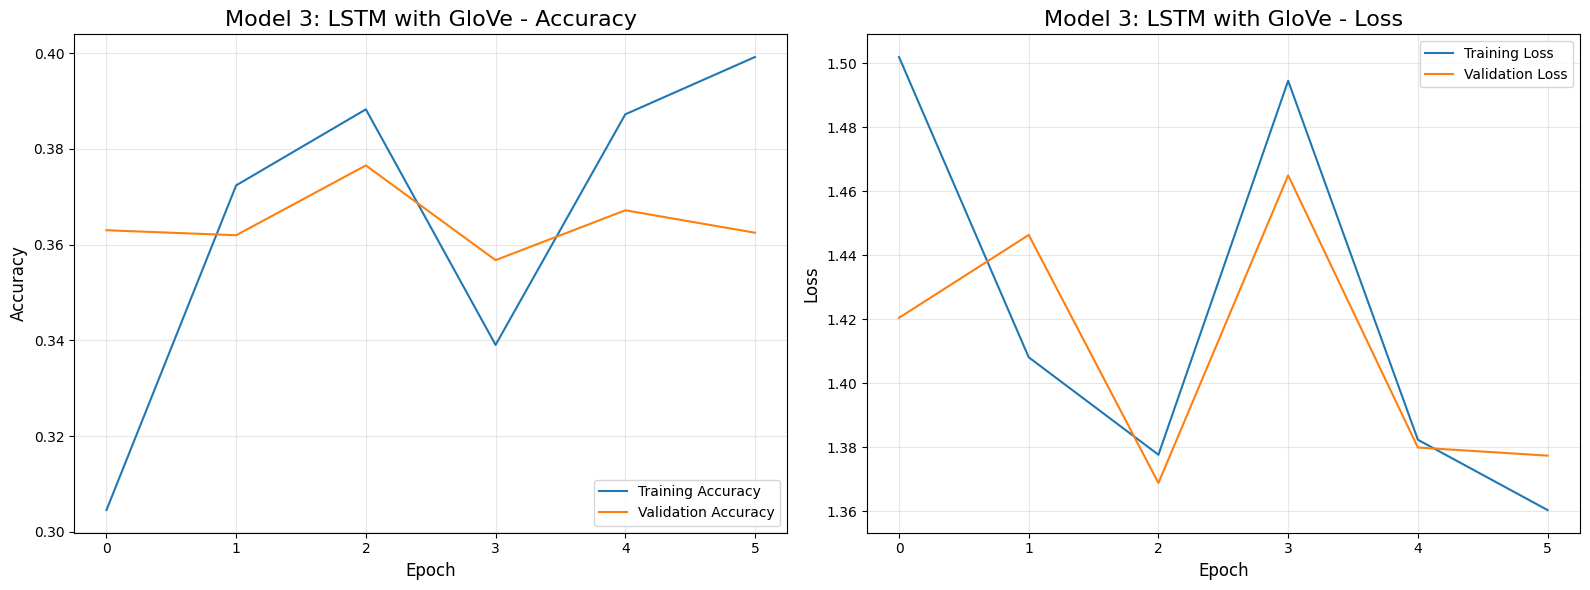


Evaluating Model 3: LSTM with GloVe
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

Model 3: LSTM with GloVe - Classification Report:
              precision    recall  f1-score   support

      1 Star       0.49      0.31      0.38       400
      2 Star       0.30      0.40      0.34       400
      3 Star       0.23      0.24      0.24       400
      4 Star       0.35      0.17      0.23       600
      5 Star       0.45      0.69      0.55       600

    accuracy                           0.37      2400
   macro avg       0.37      0.36      0.35      2400
weighted avg       0.37      0.37      0.35      2400



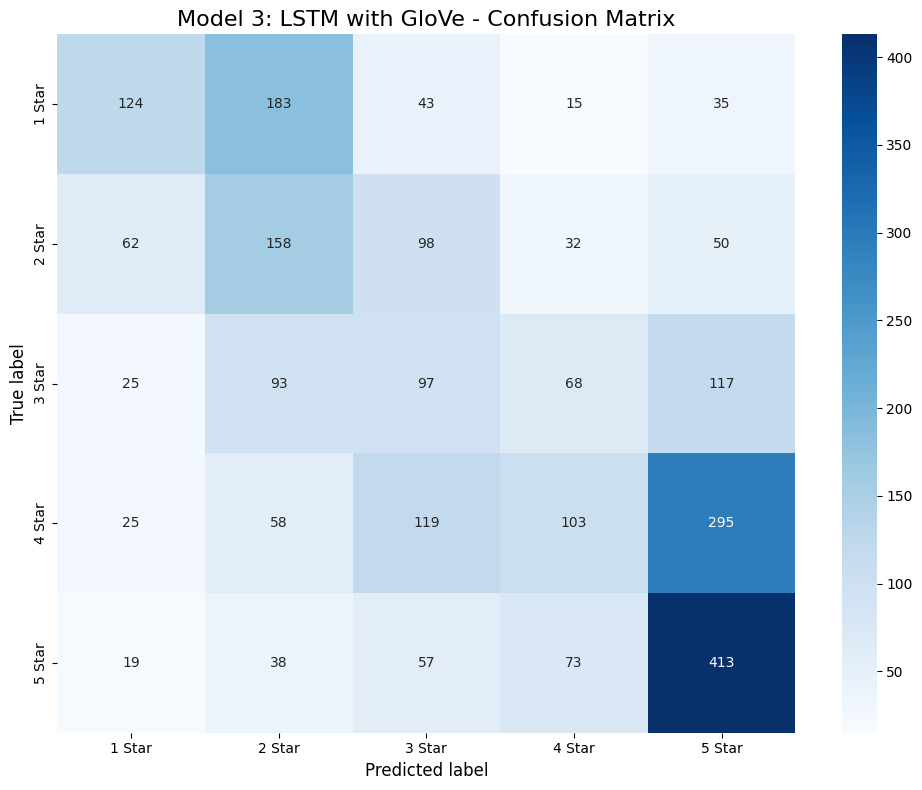

Model 3: LSTM with GloVe - Test Accuracy: 0.3729


In [42]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

# Define common training parameters
epochs = 20
batch_size = 32
validation_split = 0.2

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',            # Monitor validation loss
    patience=3,                    # Stop if no improvement for 3 epochs
    restore_best_weights=True,    # Restore weights from best epoch
    verbose=1
)

# Lists to store results
histories = []
accuracies = []
model_names = ["Simple RNN", "LSTM", "LSTM with GloVe"]

# Train and evaluate models
print("\n" + "=" * 50)
print("TRAINING AND EVALUATING MODELS")
print("=" * 50)

# ------------------------
# Train and evaluate Model 1: Simple RNN
# ------------------------
print("\nTraining Model 1: Simple RNN")
start_time = time.time()
history1 = model1.fit(
    X_train_pad, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split,
    callbacks=[early_stopping],
    verbose=1
)
end_time = time.time()
print(f"Training time for Model 1 (Simple RNN): {end_time - start_time:.2f} seconds")

# Plot learning curves
plot_learning_curves(history1, "Model 1: Simple RNN")

# Evaluate Model 1
print("\nEvaluating Model 1: Simple RNN")
acc1, y_pred1 = evaluate_model(model1, X_test_pad, y_test, "Model 1: Simple RNN")
accuracies.append(acc1)
histories.append(history1)

# ------------------------
# Train and evaluate Model 2: LSTM
# ------------------------
print("\nTraining Model 2: LSTM")
start_time = time.time()
history2 = model2.fit(
    X_train_pad, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split,
    callbacks=[early_stopping],
    verbose=1
)
end_time = time.time()
print(f"Training time for Model 2 (LSTM): {end_time - start_time:.2f} seconds")

# Plot learning curves
plot_learning_curves(history2, "Model 2: LSTM")

# Evaluate Model 2
print("\nEvaluating Model 2: LSTM")
acc2, y_pred2 = evaluate_model(model2, X_test_pad, y_test, "Model 2: LSTM")
accuracies.append(acc2)
histories.append(history2)

# ------------------------
# Train and evaluate Model 3: LSTM with GloVe
# ------------------------

# Calculate class weights based on training data distribution
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Create optimizer with lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

# Recompile model with the new optimizer
model3.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

print("\nTraining Model 3: LSTM with GloVe")
start_time = time.time()
history3 = model3.fit(
    X_train_pad, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split,
    callbacks=[early_stopping],
    class_weight=class_weight_dict,
    verbose=1
)
end_time = time.time()
print(f"Training time for Model 3 (LSTM with GloVe): {end_time - start_time:.2f} seconds")

# Plot learning curves
plot_learning_curves(history3, "Model 3: LSTM with GloVe")

# Evaluate Model 3
print("\nEvaluating Model 3: LSTM with GloVe")
acc3, y_pred3 = evaluate_model(model3, X_test_pad, y_test, "Model 3: LSTM with GloVe")
accuracies.append(acc3)
histories.append(history3)


# Part 4: Real Time Rating Perdiction GUI (3 marks , Optional Bonus)

# Overview
This document describes a simple web interface using Gradio that allows users to input product review text and receive a predicted rating (1-5 stars) in real-time.

In [43]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 143.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.1 MB/s eta 0:00:00


In [44]:
# Import required libraries
import gradio as gr
import numpy as np
import pickle
import re
import string
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import tensorflow as tf
import contractions
import os

# Download necessary NLTK resources if not already downloaded
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

# Function to clean text (same as in training code)
def clean_text(text):
    """
    Function to clean and preprocess text data

    Args:
        text (str): Input text

    Returns:
        str: Cleaned text
    """
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Expand contractions
    text = contractions.fix(text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove mentions (@user)
    text = re.sub(r'@\w+', '', text)

    # Remove hashtags (#)
    text = re.sub(r'#\w+', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords and lemmatize
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    clean_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    # Join tokens back into a string
    return ' '.join(clean_tokens)

# Function to predict the rating based on input text
def predict_rating(review_text):
    # Clean the text
    cleaned_text = clean_text(review_text)

    # Load tokenizer and max_length
    with open('tokenizer.pkl', 'rb') as f:
        tokenizer = pickle.load(f)

    with open('max_length.pkl', 'rb') as f:
        max_length = pickle.load(f)

    # Load the best model
    # Assuming Model 3 (LSTM with GloVe) performed best
    model = tf.keras.models.load_model('book_review_model.h5')

    # Convert text to sequence
    sequence = tokenizer.texts_to_sequences([cleaned_text])

    # Pad the sequence
    padded_sequence = tf.keras.preprocessing.sequence.pad_sequences(
        sequence,
        maxlen=max_length,
        padding='post',
        truncating='post'
    )

    # Make prediction
    prediction = model.predict(padded_sequence)[0]

    # Get predicted rating (add 1 because model output is 0-4, but we want 1-5)
    predicted_rating = np.argmax(prediction) + 1

    # Calculate confidence
    confidence = float(prediction[predicted_rating - 1]) * 100

    # Define sentiment based on rating
    if predicted_rating >= 4:
        sentiment = "Positive"
    elif predicted_rating == 3:
        sentiment = "Neutral"
    else:
        sentiment = "Negative"

    # Create result message
    result = f"Predicted Rating: {predicted_rating} Star{'s' if predicted_rating > 1 else ''} ({sentiment})"
    confidence_msg = f"Confidence: {confidence:.1f}%"

    # Create a bar chart using matplotlib
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(1, 1, 1)

    # Rating labels and probabilities
    ratings = [f"{i+1} Star{'s' if i > 0 else ''}" for i in range(5)]
    probs = [float(prediction[i]) * 100 for i in range(5)]

    # Create the bar chart
    bars = ax.bar(ratings, probs, color=plt.cm.viridis(np.linspace(0, 1, 5)))

    # Highlight the predicted rating
    bars[predicted_rating - 1].set_color('orange')

    # Add labels and formatting
    ax.set_xlabel('Rating')
    ax.set_ylabel('Probability (%)')
    ax.set_title('Rating Probabilities')
    ax.set_ylim(0, 100)

    # Add probability values on top of bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{probs[i]:.1f}%', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()

    return result, confidence_msg, fig

# Create the Gradio interface
def create_gui():
    with gr.Blocks(title="Book Review Rating Predictor", theme=gr.themes.Soft()) as interface:
        gr.Markdown("# 📚 Book Review Rating Predictor")
        gr.Markdown("Enter your book review below and get a predicted star rating.")

        with gr.Row():
            with gr.Column(scale=3):
                input_text = gr.Textbox(
                    label="Your Book Review",
                    placeholder="Type your book review here...",
                    lines=5
                )
                submit_btn = gr.Button("Predict Rating", variant="primary")

            with gr.Column(scale=2):
                result_text = gr.Textbox(label="Prediction Result", interactive=False)
                confidence_text = gr.Textbox(label="Confidence", interactive=False)

                # Bar chart for rating probabilities
                rating_chart = gr.Plot(
                    label="Rating Probabilities"
                )

        # Examples
        gr.Markdown("### Try these examples:")
        examples = gr.Examples(
            examples=[
                ["This book was absolutely amazing! I couldn't put it down and the characters were so well developed."],
                ["The book was okay, but the plot was predictable and some parts were boring."],
                ["Worst book I've ever read. Complete waste of money and time."],
                ["I enjoyed this book. The storyline was interesting though it dragged a bit in the middle."],
                ["This book changed my life! The writing is beautiful and the story is so captivating."]
            ],
            inputs=input_text
        )

        # Set up the click event
        submit_btn.click(
            fn=predict_rating,
            inputs=input_text,
            outputs=[result_text, confidence_text, rating_chart]
        )

        # Add information about the model
        gr.Markdown("""
        ### About This Predictor
        This tool uses a deep learning model (LSTM with GloVe embeddings) trained on book reviews to predict
        star ratings on a scale of 1 to 5 stars.

        - **1-2 Stars**: Negative sentiment
        - **3 Stars**: Neutral sentiment
        - **4-5 Stars**: Positive sentiment

        The confidence percentage indicates how certain the model is about its prediction.
        """)

    return interface

# Check if model exists, if not create dummy model for demo purposes
if not os.path.exists('book_review_model.h5'):
    # Create a simple dummy model for demonstration
    print("Model file not found. Creating a dummy model for demonstration.")

    # Define a simple model architecture
    vocab_size = 10000
    embedding_dim = 50
    max_length = 100

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Save the dummy model
    model.save('book_review_model.h5')

    # Create dummy tokenizer and max_length if they don't exist
    if not os.path.exists('tokenizer.pkl'):
        tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size)
        tokenizer.fit_on_texts(["dummy text for tokenizer"])
        with open('tokenizer.pkl', 'wb') as f:
            pickle.dump(tokenizer, f)

    if not os.path.exists('max_length.pkl'):
        with open('max_length.pkl', 'wb') as f:
            pickle.dump(max_length, f)

# Create and launch the interface
interface = create_gui()

# Launch the app
if __name__ == "__main__":
    interface.launch()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Model file not found. Creating a dummy model for demonstration.
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0ded33688755cb96d5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
